## Generate the Dataset

In [1]:
import numpy as np


def generate_time_series(batch_size, n_steps):
    """This function creates as many time series as requested (via the
        batch_size argument), each of length n_steps, and there is just one
        value per time step in each series
    
    Returns:
        Numpy array:  of shape [batch size, time steps, 1], where
        each series is the sum of two sine waves of fixed amplitudes but random
        frequencies and phases, plus a bit of noise
    """
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)


In [2]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [3]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

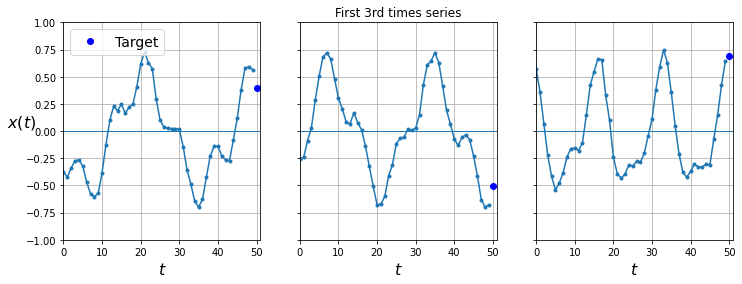

In [4]:
import matplotlib.pyplot as plt


def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")


fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    if col == 1:
        plt.title("First 3rd times series")

    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col == 0 else None),
                legend=(col == 0))
plt.show()


## Using a Simple RNN

By default, recurrent layers in Keras only return the final output. To make them
return one output per time step, you must set `return_sequences=True`

In [5]:
import tensorflow as tf
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
219/219 [==============================] - 6s 11ms/step - loss: 0.0133 - val_loss: 0.0109
Epoch 2/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 3/10
219/219 [==============================] - 2s 9ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 4/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 5/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 6/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 7/10
219/219 [==============================] - 2s 11ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 8/10
219/219 [==============================] - 2s 8ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 9/10
219/219 [==============================] - 2s 11ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 10/10
219/219 [==============================] - 3s 13ms/step - loss: 0.0114 - val_loss: 0.

In [6]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0110


0.010981950908899307

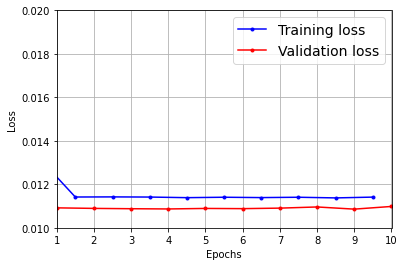

In [7]:
import matplotlib as mpl

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 10, 0.01, 0.02])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)


plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()


63/63 [==============================] - 0s 3ms/step


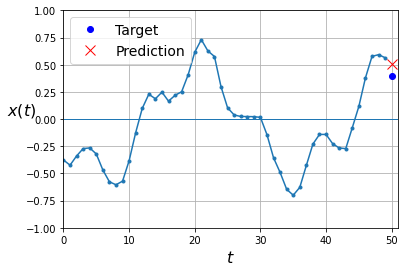

In [8]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## Deep RNNs

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
219/219 [==============================] - 10s 26ms/step - loss: 0.0237 - val_loss: 0.0064
Epoch 2/10
219/219 [==============================] - 4s 20ms/step - loss: 0.0054 - val_loss: 0.0046
Epoch 3/10
219/219 [==============================] - 4s 20ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 4/10
219/219 [==============================] - 4s 20ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 5/10
219/219 [==============================] - 5s 23ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 6/10
219/219 [==============================] - 5s 21ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 7/10
219/219 [==============================] - 5s 21ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 8/10
219/219 [==============================] - 5s 21ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 9/10
219/219 [==============================] - 4s 20ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 10/10
219/219 [==============================] - 4s 20ms/step - loss: 0.0030 - val_l

In [10]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0029


0.002852620556950569

Asegúrese de configurar `return_sequences=True` para todas las capas recurrentes (excepto la
última, si solo le importa la última salida). Si no lo hace, generarán una matriz 2D (que
contiene solo la salida del último paso de tiempo) en lugar de una matriz 3D (que contiene
salidas para todos los pasos de tiempo), y la siguiente capa recurrente se quejará de que no la
está alimentando secuencias en el formato 3D esperado. 
   
  


>Make the second `SimpleRNN` layer return only the last output:
 
Podría ser preferible reemplazar la capa de salida con una capa **densa** : ya que  se ejecutaría un poco más
rápido, la precisión sería aproximadamente la misma y nos permitiría elegir cualquier función de
activación de salida que queramos. Si realiza este cambio, también asegúrese de eliminar
`return_sequences=True` de la segunda (ahora última) capa recurrente

In [11]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
219/219 [==============================] - 9s 30ms/step - loss: 0.0224 - val_loss: 0.0072
Epoch 2/10
219/219 [==============================] - 3s 15ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 3/10
219/219 [==============================] - 3s 15ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 4/10
219/219 [==============================] - 3s 15ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 5/10
219/219 [==============================] - 3s 15ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 6/10
219/219 [==============================] - 3s 16ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 7/10
219/219 [==============================] - 3s 16ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 8/10
219/219 [==============================] - 3s 15ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/10
219/219 [==============================] - 3s 15ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 10/10
219/219 [==============================] - 3s 15ms/step - loss: 0.0030 - val_lo

In [12]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 13ms/step - loss: 0.0028


0.0027589278761297464

In [13]:
np.random.seed(43) # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
y_pred_one= model.predict(X[:, 0:])[:, np.newaxis, :]

np.concatenate([X, y_pred_one], axis=1).shape
# for step_ahead in range(10):
#     y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
#     X = np.concatenate([X, y_pred_one], axis=1)

# Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 356ms/step


(1, 51, 1)

## Forecasting Several Steps Ahead

La primera opción es usar el modelo que ya entrenamos, hacer que prediga el siguiente
valor, luego agregar ese valor a las entradas (actuando como si este valor predicho
realmente hubiera ocurrido), y usar el modelo nuevamente para predecir el
siguiente valor, y así sucesivamente, como en el siguiente código

In [14]:
np.random.seed(43)  # not 42, as it would give the first series in the train set

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

for step_ahead in range(10):
    # obtener la prediccion y crear un nuevo eje para concatenar la prediccion con la entrada X
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]

    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]
Y_pred.shape


1/1 [==============================] - 0s 89ms/step


(1, 10, 1)

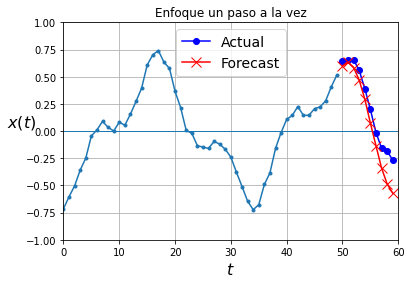

In [23]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(
        np.arange(n_steps, n_steps + ahead),
        Y_pred[0, :, 0],
        "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
    


plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.title('Enfoque un paso a la vez')
plt.show()


La segunda opcion es entrenar una RNN para predecir los próximos 10 valores de una vez. 
* La entrada tendrá las dimensiones **(cantidad de muestras *x* time_steps(en este caso 50) *x* dimensionality en este caso 1)**
* Target tendra la dimension **(cantidad de muestras *x* time_steps_to_predict(en este caso 10))**

In [24]:
# obtenr el conjunto de datos manuel 
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)

X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

X_test.shape, Y_test.shape


((1000, 50, 1), (1000, 10))

In [29]:
#  naive predictions
Y_naive_pred = np.tile(X_valid[:, -1], 10) # take the last time step value, and repeat it 10 times
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [31]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),

    # menos par ala ultima capa recurrente return_sequences=True
    keras.layers.SimpleRNN(20),

    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=8,
                    validation_data=(X_valid, Y_valid))


Epoch 1/8
219/219 [==============================] - 5s 17ms/step - loss: 0.0702 - val_loss: 0.0394
Epoch 2/8
219/219 [==============================] - 3s 15ms/step - loss: 0.0316 - val_loss: 0.0238
Epoch 3/8
219/219 [==============================] - 3s 16ms/step - loss: 0.0210 - val_loss: 0.0193
Epoch 4/8
219/219 [==============================] - 3s 15ms/step - loss: 0.0166 - val_loss: 0.0191
Epoch 5/8
219/219 [==============================] - 3s 16ms/step - loss: 0.0146 - val_loss: 0.0123
Epoch 6/8
219/219 [==============================] - 4s 17ms/step - loss: 0.0132 - val_loss: 0.0117
Epoch 7/8
219/219 [==============================] - 4s 17ms/step - loss: 0.0124 - val_loss: 0.0131
Epoch 8/8
219/219 [==============================] - 4s 17ms/step - loss: 0.0119 - val_loss: 0.0105


1/1 [==============================] - 0s 239ms/step


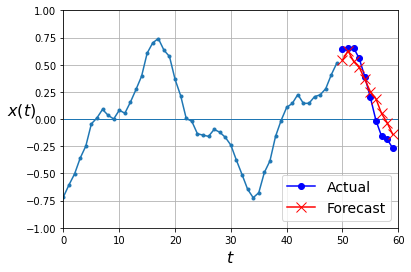

In [37]:
np.random.seed(43)

# generar una nueva serie 
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

La tercera opción es entrenar una red que para cada paso del tiempo prediga los siguientes 10 valores.
* La entrada tendrá las dimensiones **(cantidad de muestras *x* time_steps(en este caso 50) *x* dimensionality en este caso 1)**
* Target tendra la dimension **(cantidad de muestras *x* time_steps(en este caso 50) *x* time_steps_to_predict(10 en este caso) )**

In [45]:
np.random.seed(42)

n_steps = 50
# obtener el conjunto de datos 
series = generate_time_series(10000, n_steps + 10)

X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

# preparar la variable Targets para todo el conjunto de datos ponemos en una arreglo de (50X10) 
# los valores desde el 0 hasta el 50, luego desde el 1 hasta el 51 y asi sucesivamente llegando al 10 hasta el 6. Lo que con llevara a que las filas contegan los valores deseados 

Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]

Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

Para implementar **sequence-to-sequence** model se debe establecer `return_sequences=True` en todas las capas recurrentes (incluso la última), y
debemos aplicar la capa Densa de salida en cada paso de tiempo. Keras ofrece
una capa `TimeDistributed` para este mismo propósito: envuelve cualquier capa (por
ejemplo, una capa densa) y la aplica en cada paso de tiempo de su secuencia de entrada.
Hace esto de manera eficiente, remodelando las entradas para que cada paso de tiempo
se trate como una instancia separada (es decir, remodela las entradas de  *[batch size, time steps,input dimensions] to [batch size × time steps, input dimensions]*; en este ejemplo, el número de input dimension
es 20 porque la capa SimpleRNN anterior tiene 20 unidades),
  
  luego ejecuta la capa
densa y, finalmente, remodela las salidas de nuevo a secuencias (es decir, remodela
las salidas de *[batch size × time steps, output dimensions] to [batch size, time steps, output dimensions]*; en este ejemplo, el número de output dimension es 10, ya que la capa densa tiene 10 unidades)


In [46]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])


def last_time_step_mse(Y_true, Y_pred):
    """ Métrica personalizada para la evaluación, para calcular solo el
    MSE sobre la salida en el último paso de tiempo:"""

    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


model.compile(loss="mse", optimizer=keras.optimizers.Adam(
    learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=8,
                    validation_data=(X_valid, Y_valid))


Epoch 1/8
219/219 [==============================] - 5s 17ms/step - loss: 0.0502 - last_time_step_mse: 0.0388 - val_loss: 0.0350 - val_last_time_step_mse: 0.0215
Epoch 2/8
219/219 [==============================] - 3s 15ms/step - loss: 0.0344 - last_time_step_mse: 0.0214 - val_loss: 0.0321 - val_last_time_step_mse: 0.0193
Epoch 3/8
219/219 [==============================] - 3s 15ms/step - loss: 0.0300 - last_time_step_mse: 0.0167 - val_loss: 0.0286 - val_last_time_step_mse: 0.0162
Epoch 4/8
219/219 [==============================] - 4s 16ms/step - loss: 0.0283 - last_time_step_mse: 0.0159 - val_loss: 0.0263 - val_last_time_step_mse: 0.0139
Epoch 5/8
219/219 [==============================] - 3s 15ms/step - loss: 0.0262 - last_time_step_mse: 0.0138 - val_loss: 0.0236 - val_last_time_step_mse: 0.0104
Epoch 6/8
219/219 [==============================] - 3s 15ms/step - loss: 0.0243 - last_time_step_mse: 0.0116 - val_loss: 0.0227 - val_last_time_step_mse: 0.0105
Epoch 7/8
219/219 [=========

In [51]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 28ms/step


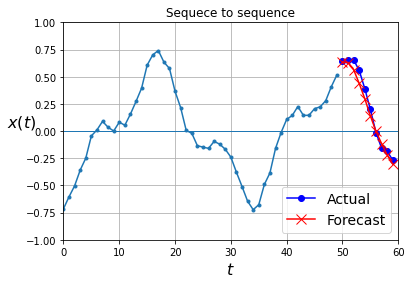

In [52]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.title('Sequece to sequence')
plt.show()

The **Dense layer** actually supports sequences as inputs, for the sake of clarity,
however, we will keep using TimeDistributed(Dense(10)) because it 
makes it clear that the Dense layer is applied independently at each time
step and that the model will output a sequence, not just a single vector